In [1]:
# Import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from importlib import reload
import os
import time

# Import the MFI library 
import MFI_lib2D as lib2
import MFI_class2D

# Set the path to the notebook and the data folder (and figures folder if needed)
if 'path_notebook' not in globals(): path_notebook = os.getcwd()
print("The path to the notebook is:", path_notebook)

if 'path_data' not in globals():
    if not os.path.isdir("_data_convergence_analysis/pot3/"): print("\nThe data folder \"_data_convergence_analysis/pot3/\" does not exist. Creating new folder."); os.mkdir(path_notebook + "/_data_convergence_analysis/pot3/"); 
    path_data = path_notebook + "/_data_convergence_analysis/pot3/"
print("The data folder is:", path_data)
# path_figures = "/home/ucecabj/Pictures/MFI_figures/"

# Set the plotting parameters
for _plt_parameters_ in [0]:
    from matplotlib import rc
    plt.rcParams.update({ "text.usetex": True, "font.family": "serif", "font.serif": ["Helvetica"], "font.size": 12, "axes.titleweight": "bold"})
    plw = 0.6  # width of (box line, tick line, ...)
    plt.rcParams.update({"axes.linewidth": plw, "figure.figsize": (4,3)}) 
    plt.rcParams.update({"xtick.top": True, "xtick.direction": "in", "xtick.major.width": plw, "xtick.minor.width": plw, "xtick.minor.visible": True, "xtick.major.size": 5})
    plt.rcParams.update({"ytick.right": True, "ytick.direction": "in", "ytick.major.width": plw, "ytick.minor.width": plw, "ytick.minor.visible": True, "ytick.major.size": 5})


The path to the notebook is: /home/ucecabj/Desktop/MFI_git/MFI_class2D
The data folder is: /home/ucecabj/Desktop/MFI_git/MFI_class2D/_data_convergence_analysis/pot3/


### Define Potential and default parameters

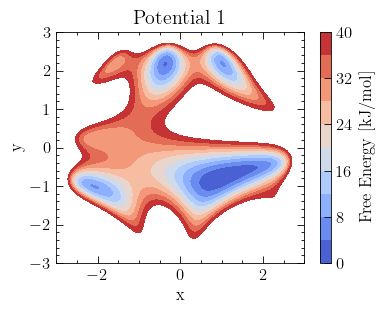

In [2]:
# Define the grid, the potential, the string of the potential and the FES cutoff
grid = np.linspace(-3, 3, 100); 
X, Y = np.meshgrid(grid, grid)
pot3 = np.exp(X-2)**5 + np.exp(-X-2)**5 + np.exp(Y-2)**5 + np.exp(-Y-2)**5 + 13*np.sin(2*X*Y) + 17*np.sin(2*Y) + 0.137*X**4*Y**4
pot3 = pot3 - np.min(pot3)
dpot3_dy, dpot3_dx = np.gradient(pot3, grid, grid)
pot3_string = "exp(x-2)^5+exp(-x-2)^5+exp(y-2)^5+exp(-y-2)^5+13*sin(2*x*y)+17*sin(2*y)+0.137*x^4*y^4"
plumed_dat_text = f"p: DISTANCE ATOMS=1,2 COMPONENTS\nff: MATHEVAL ARG=p.x,p.y FUNC=({pot3_string}) PERIODIC=NO\nbb: BIASVALUE ARG=ff\n"
FES_cutoff = 40

# Define plumed grid
[plX, plY, pl_min, pl_max, pl_n, pl_extra] = lib2.get_plumed_grid_2D(X, Y, [-4,-4], [4,4])

# plot the free energy surface
plt.contourf(X, Y, pot3, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1"); plt.show()


In [3]:
# default parameters for the MFI class
default_params = {  "X":X, "Y":Y, "Z":pot3, "bw":[0.1, 0.1], #"dZ_dX":dpot3_dx, "dZ_dY":dpot3_dy,
                    "System":"Langevin", "plumed_dat_text":plumed_dat_text, "plX":plX, "plY":plY, "simulation_steps":3_000_000, 
                    "position_pace":20, "n_pos_per_window":10, "metad_pace":200, 
                    "metad_width":[0.1, 0.1], "metad_height":2, "biasfactor":20,
                    "Bias_sf":1, "gaus_filter_sigma":None,
                    "len_error_list":100,
                    "FES_cutoff":FES_cutoff, "calculate_FES_st_dev":False, "bootstrap_iter":50, "record_forces_e":True, "save_error_progression":False,
                    "simulation_folder_path": path_data, "print_info": False}

### Run 100 Long simulation for reference

AAD = 0.5174764921103155


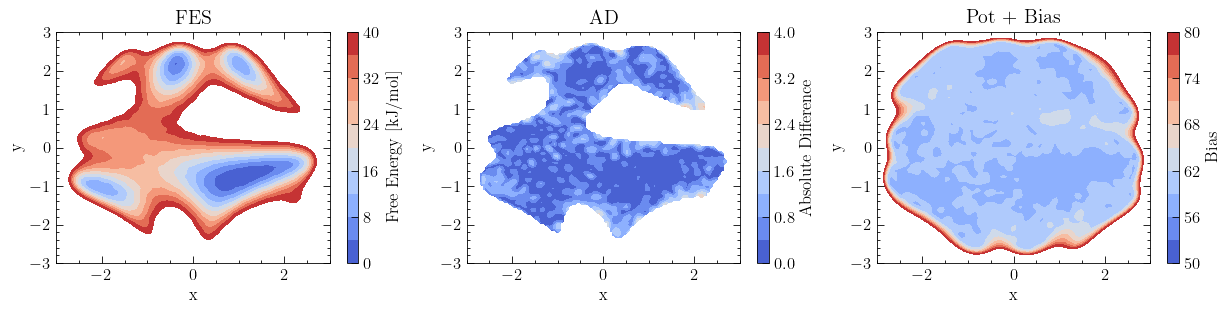

In [14]:
# plot MFI_long error
plt.figure(figsize=(15, 3))

fes = MFI_long.FES
ad = np.abs(fes - pot3) 
ad = np.where(pot3 > FES_cutoff, 0, ad)
print(f"AAD = {np.sum(ad)/(np.count_nonzero(ad))}")
bias_last = MFI_long.Bias

plt.subplot(1, 3, 1)
plt.contourf(X, Y, fes, levels=np.linspace(0, FES_cutoff, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("FES")

plt.subplot(1, 3, 2)
plt.contourf(X, Y, lib2.zero_to_nan(ad), levels=np.linspace(0, 4, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference"); plt.xlabel("x"); plt.ylabel("y"); plt.title("AD")

plt.subplot(1, 3, 3)
plt.contourf(X, Y, pot3 + bias_last, levels=np.linspace(50, 80, 11), cmap='coolwarm'); plt.colorbar(label="Bias"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Pot + Bias"); 

In [4]:
# Run 100 long simulations
long_sim_params = {**default_params}
long_sim_params.update({"save_error_progression":True})#, "n_pos":50_000})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_long_{i_sim}"
    long_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_long = MFI_class2D.MFI2D(**long_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_long.run_simulation()
        MFI_long.analyse_data()
        t, aofe, aad, aBS = MFI_long.Avr_Error_list[:,0], MFI_long.Avr_Error_list[:,2], MFI_long.Avr_Error_list[:, MFI_long.aad_index], MFI_long.Avr_Error_list[:, MFI_long.abs_error_index]
        
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 89 | Final Error: Aofe = 0.9354, AAD = 0.5811, ABS = 0.4365
Simulation 90 | Final Error: Aofe = 0.9318, AAD = 0.4451, ABS = 0.3628
Simulation 91 | Final Error: Aofe = 0.9308, AAD = 0.5107, ABS = 0.4113
Simulation 92 | Final Error: Aofe = 0.9440, AAD = 0.7333, ABS = 0.5124
Simulation 93 | Final Error: Aofe = 0.9440, AAD = 0.6038, ABS = 0.3631
Simulation 94 | Final Error: Aofe = 0.9311, AAD = 0.4934, ABS = 0.4480
Simulation 95 | Final Error: Aofe = 0.9355, AAD = 0.5848, ABS = 0.4010
Simulation 96 | Final Error: Aofe = 0.9375, AAD = 0.5980, ABS = 0.4756
Simulation 97 | Final Error: Aofe = 0.9266, AAD = 0.6072, ABS = 0.3686
Simulation 98 | Final Error: Aofe = 0.9174, AAD = 0.4729, ABS = 0.4140
Simulation 99 | Final Error: Aofe = 0.9400, AAD = 0.5024, ABS = 0.3316
Simulation 100 | Final Error: Aofe = 0.9322, AAD = 0.4676, ABS = 0.3645


Mean Final AAD: 0.4879 +- 0.0281 || Mean Final ABS: 0.4379 +- 0.0562


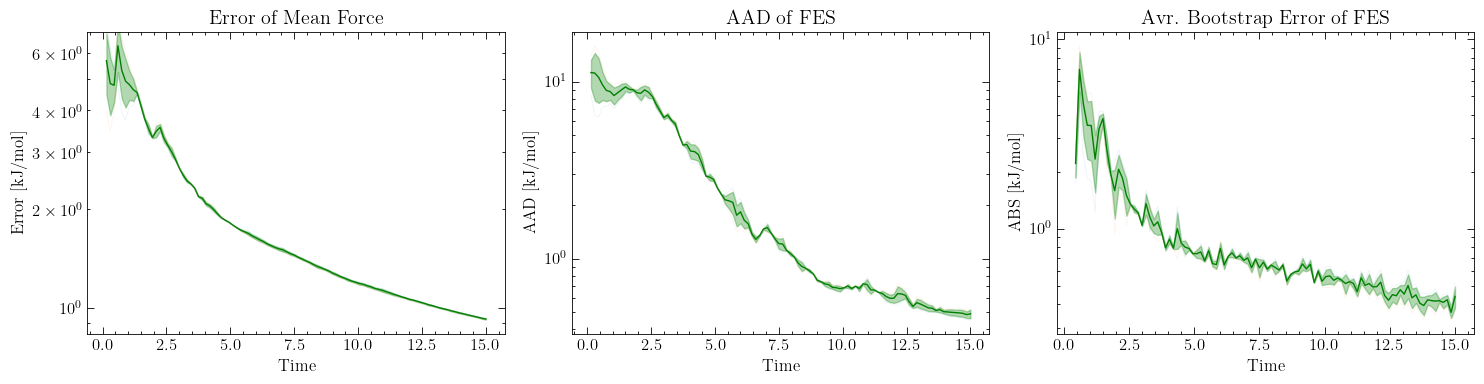

In [5]:
# Statistical Analysis of 100 long simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                                                                        return_results=True, plot=False, plot_log=True)
time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long, mean_abs_long, ste_abs_long = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
# plt.ylim(0, 20)

print(f"Mean Final AAD: {mean_aad_long[-1]:.4f} +- {ste_aad_long[-1]:.4f} || Mean Final ABS: {mean_abs_long[-1]:.4f} +- {ste_abs_long[-1]:.4f}")
plt.show()

### Run 100 Exploration simulations

In [56]:
# Run 100 exploration simulations
expl_sim_params = {**default_params}
expl_sim_params.update({"save_error_progression":True})#, "n_pos":2_500})
expl_sim_params.update({"simulation_steps":300_000, "metad_height":5, "biasfactor":200, "len_error_list":25})

t_collection, aofe_collection, aad_collection = [], [], []

for i_sim in range(1,101):
    
    sim_ID = f"_expl_{i_sim}"
    expl_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_expl = MFI_class2D.MFI2D(**expl_sim_params)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_expl.run_simulation()
        MFI_expl.analyse_data()
        t, aofe, aad = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index]
        
        print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(pot3 + MFI_expl.Bias):.4f}", end=" | ")
        # MFI_expl.plot_res()
        # lib2.plot_hills_trajectory(MFI_expl.hills)


    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Simulation 1 (exists) | Final Error: Aofe = 4.3579, AAD = 2.1395
Simulation 2 (exists) | Final Error: Aofe = 4.3025, AAD = 2.0465
Simulation 3 (exists) | Final Error: Aofe = 4.4390, AAD = 3.5821
Simulation 4 (exists) | Final Error: Aofe = 4.3741, AAD = 2.2745
Simulation 5 (exists) | Final Error: Aofe = 4.3319, AAD = 1.9957
Simulation 6 (exists) | Final Error: Aofe = 4.3441, AAD = 3.6136
Simulation 7 (exists) | Final Error: Aofe = 4.4821, AAD = 3.3909
Simulation 8 (exists) | Final Error: Aofe = 4.4327, AAD = 2.1939
Simulation 9 (exists) | Final Error: Aofe = 4.3968, AAD = 1.9891
Simulation 10 (exists) | Final Error: Aofe = 4.3622, AAD = 2.1121
Simulation 11 (exists) | Final Error: Aofe = 4.4535, AAD = 2.5803
Simulation 12 (exists) | Final Error: Aofe = 4.3855, AAD = 2.0438
Simulation 13 (exists) | Final Error: Aofe = 4.3188, AAD = 2.7929
Simulation 14 (exists) | Final Error: Aofe = 4.3229, AAD = 2.0053
Simulation 15 (exists) | Final Error: Aofe = 4.2644, AAD = 1.7630
Simulation 16 (exis

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Mean Final AAD: 2.1663 +- 0.0414


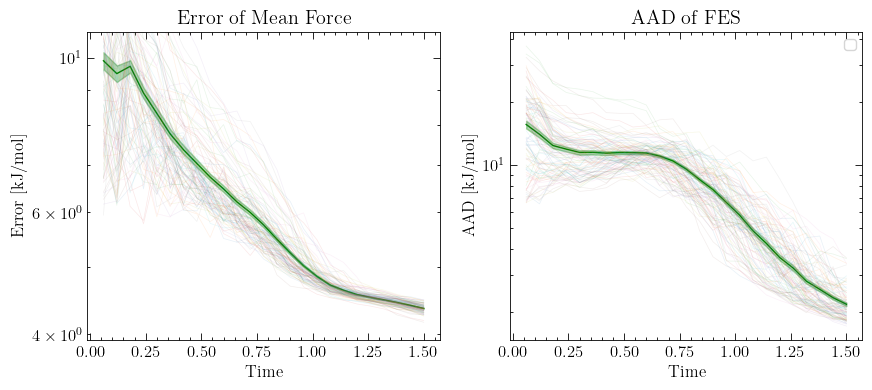

In [40]:
# Statistical Analysis of 100 exploration simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=True)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)

print(f"Mean Final AAD: {mean_aad_expl[-1]:.4f} +- {ste_aad_expl[-1]:.4f}")

# plt.plot(t, aad_collection[88], label="run 88")
plt.legend(fontsize=10)
plt.show()


In [55]:
# # # Plot all exploration simulations to find a representative one to use for metad stage
# t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
# t = t_collection[0]

# for j in range(1, 21):
    
#     time_expl, mean_ofe_expl, ste_ofe_expl, mean_aad_expl, ste_aad_expl = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, return_results=True, plot=False, plot_log=False)
#     plt.subplot(1,2,1) 
#     for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
#     plt.subplot(1,2,2)
#     for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)    
    
#     for jj in range((j-1)*5, (j)*5):
        
#         print(f"Simulation {jj+1}", end=" | ")
        
#         plt.subplot(1,2,1)
#         plt.plot(t, aofe_collection[jj], label=f"{jj+1}", alpha=0.8)
#         plt.subplot(1,2,2)
#         plt.plot(t, aad_collection[jj], label=f"{jj+1}: {aad_collection[jj][-1]:.4f}", alpha=0.8)
    
#     print("")    
#     plt.legend(fontsize=10)
#     plt.yscale("log")
#     plt.show() 
                                                                                                        

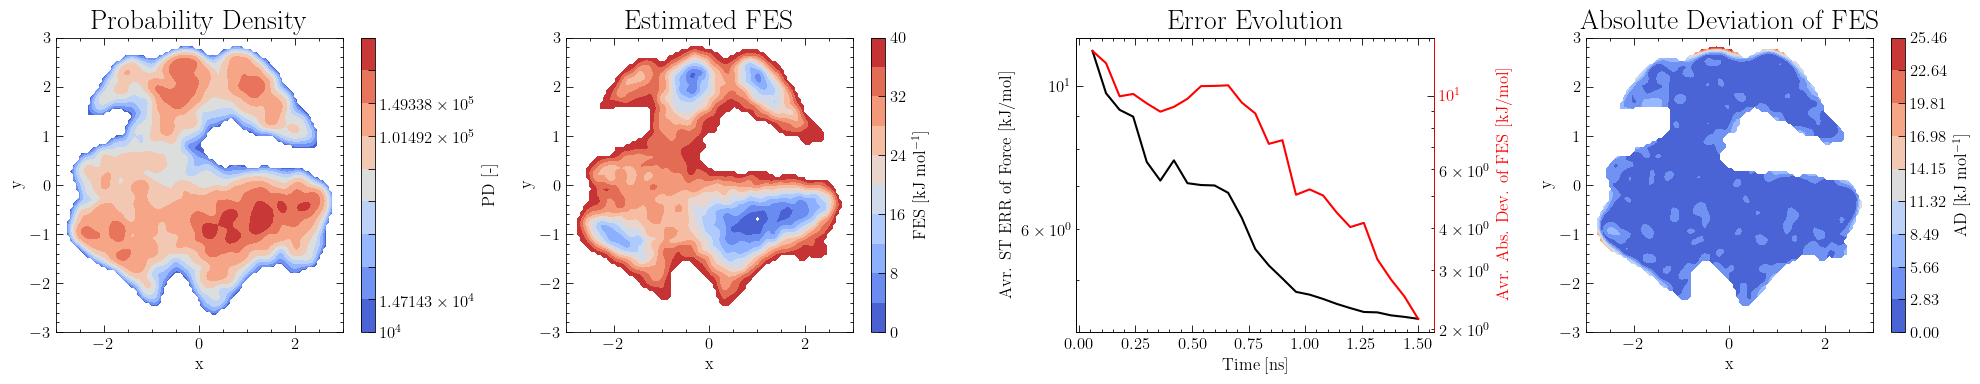

ready to show


In [10]:
# Exploration Simulation used for MetaD stage
new_params = {**default_params}
new_params.update({"ID":"_expl_1", "len_error_list":25, "save_results":True})

MFI_expl = MFI_class2D.MFI2D(**new_params)
MFI_expl.analyse_data()

print(F"Final Error: Aofe = {MFI_expl.Aofe:.4f}, AAD = {MFI_expl.AAD:.4f}")
print(f"MIN(FES+Bias) = {np.min(MFI_expl.FES + MFI_expl.Bias):.4f}, MIN(Z+Bias) = {np.min(pot3 + MFI_expl.Bias):.4f}")

MFI_expl.plot_res(["AD"])
lib2.plot_3D_plotly(MFI_expl.X, MFI_expl.Y, MFI_expl.Z + MFI_expl.Bias, range_min=0, range_max=np.min(pot3 + MFI_expl.Bias)*2)
t_expl, v_expl, aofe_expl, aad_expl, abs_expl = MFI_expl.Avr_Error_list[:,0], MFI_expl.Avr_Error_list[:,1], MFI_expl.Avr_Error_list[:,2], MFI_expl.Avr_Error_list[:, MFI_expl.aad_index], MFI_expl.Avr_Error_list[:, MFI_expl.abs_error_index]
force_terms_expl, sim_time_expl, fes_expl = MFI_expl.force_terms, MFI_expl.sim_time, MFI_expl.FES
forces_e_list_expl = MFI_expl.forces_e_list


### 2nd Stage - 1x MetaD simulation

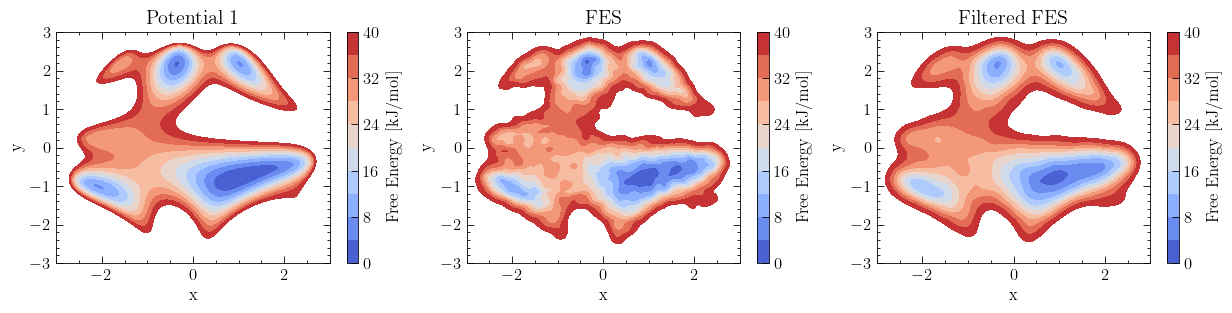

AAD FES: 1.5614
AAD FES_filtered: 1.6429


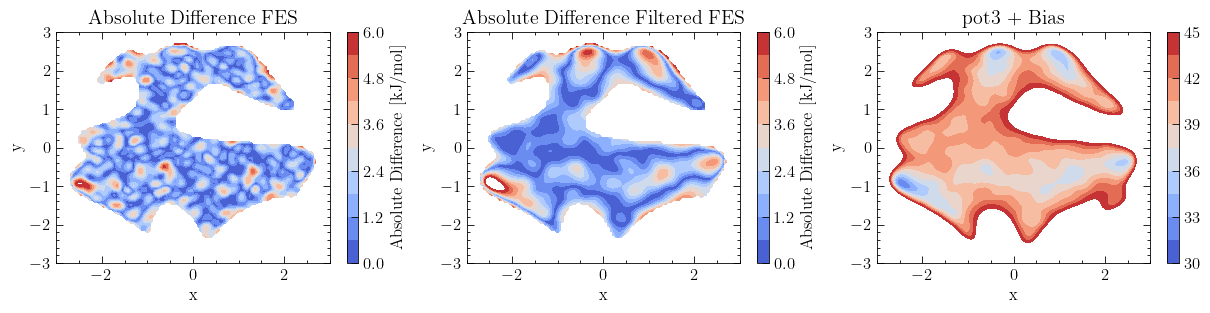

In [54]:
# plot potential, FES, filered FES, AD, AAD, AD_filtered, AAD_filtered, Bias+Pot
from scipy.ndimage import gaussian_filter
gfs = 2
fes = MFI_expl.FES; fes_filered = gaussian_filter(fes, sigma=gfs)
for _plot_ in [1]:
    plt.figure(figsize=(15,3))
    plt.subplot(1,3,1)
    plt.contourf(X, Y, pot3, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1")

    plt.subplot(1,3,2)
    plt.contourf(X, Y, fes, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("FES")

    plt.subplot(1,3,3)
    plt.contourf(X, Y, fes_filered, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Filtered FES")
    plt.show()

    plt.figure(figsize=(15,3))
    ad_fes = np.where(pot3 <= 40, np.abs(fes - pot3), 0)
    print(f"AAD FES: {np.sum(ad_fes)/(np.count_nonzero(ad_fes)):.4f}")
    plt.subplot(1,3,1)
    plt.contourf(X, Y, lib2.zero_to_nan(ad_fes), levels=np.linspace(0, 6, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Absolute Difference FES")

    ad_fes_filtered = np.where(pot3 <= 40, np.abs(fes_filered - pot3), 0)
    print(f"AAD FES_filtered: {np.sum(ad_fes_filtered)/(np.count_nonzero(ad_fes)):.4f}")

    plt.subplot(1,3,2)
    plt.contourf(X, Y, lib2.zero_to_nan(ad_fes_filtered), levels=np.linspace(0, 6, 11), cmap='coolwarm'); plt.colorbar(label="Absolute Difference [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Absolute Difference Filtered FES")
    
    bias, fx_bias, fy_bias, file_path_dat = lib2.make_external_bias_2D(X, Y, FES=fes, Bias_sf=1, gaus_filter_sigma=gfs, FES_cutoff=40, return_array=True)

    
    plt.subplot(1,3,3)
    plt.contourf(X, Y, pot3+bias, levels=np.linspace(30, 45, 11), cmap='coolwarm'); plt.colorbar(label=""); plt.xlabel("x"); plt.ylabel("y"); plt.title("pot3 + Bias")
    plt.show()

In [8]:
## laod results from the exploration simulation
res = lib2.load_pkl(path_data + f"MFI_results_expl_1.pkl")[1]
force_terms_expl = res[0]
fes_expl = lib2.FFT_intg_2D(force_terms_expl[2], force_terms_expl[3], [-3,-3], [3, 3])
sim_time_expl = res[1].T[0][-1]
forces_e_list_expl = res[-1]


In [16]:
# Run 100 MetaD simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":2_700_000, "len_error_list":100, "save_error_progression":True, "save_results":True})
metad_sim_params.update({"metad_height":2, "biasfactor":5, "gaus_filter_sigma":2})
metad_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_metad_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]
        
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 3 | Final Error: Aofe = 0.8859, AAD = 0.6723, ABS = 0.3534
Simulation 4 | Final Error: Aofe = 0.8923, AAD = 0.6626, ABS = 0.4507
Simulation 5 | Final Error: Aofe = 0.8889, AAD = 0.6613, ABS = 0.4744
Simulation 6 | Final Error: Aofe = 0.8908, AAD = 0.7124, ABS = 0.4355
Simulation 7 | Final Error: Aofe = 0.8907, AAD = 0.6967, ABS = 0.4880
Simulation 8 | Final Error: Aofe = 0.8875, AAD = 0.6623, ABS = 0.4328
Simulation 9 | Final Error: Aofe = 0.8929, AAD = 0.7188, ABS = 0.4106
Simulation 10 | Final Error: Aofe = 0.8932, AAD = 0.7090, ABS = 0.3103
Simulation 11 | Final Error: Aofe = 0.8905, AAD = 0.6687, ABS = 0.3935
Simulation 12 | Final Error: Aofe = 0.8898, AAD = 0.6519, ABS = 0.3391
Simulation 13 | Final Error: Aofe = 0.8935, AAD = 0.6774, ABS = 0.3891
Simulation 14 | Final Error: Aofe = 0.8942, AAD = 0.7049, ABS = 0.4340
Simulation 15 | Final Error: Aofe = 0.8890, AAD = 0.6796, ABS = 0.4092
Simulation 16 | Final Error: Aofe = 0.8832, AAD = 0.6681, ABS = 0.3837
Simulation 17

Mean Final AAD: 0.6854 +- 0.0031 || Mean Final ABS: 0.3961 +- 0.0051


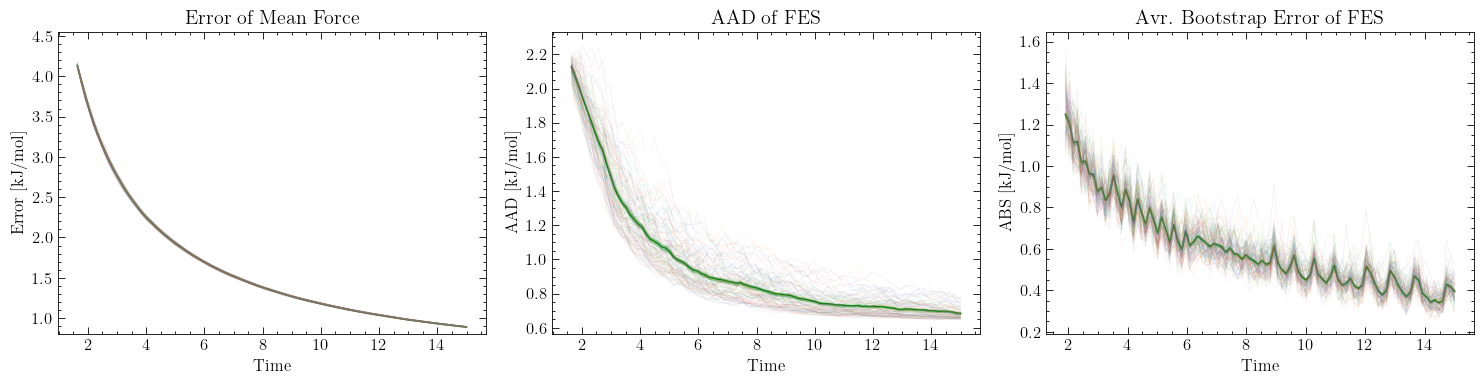

In [17]:
# Statistical Analysis of 100 MetaD simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, 
                                                return_results=True, plot=False, plot_log=False)
time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad, mean_abs_metad, ste_abs_metad = avr_results

plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metad[-1]:.4f} +- {ste_aad_metad[-1]:.4f} || Mean Final ABS: {mean_abs_metad[-1]:.4f} +- {ste_abs_metad[-1]:.4f}")
plt.show()

In [18]:
# Run 100 MetaD ALTERNATIVE simulations
metad_sim_params = {**default_params}
metad_sim_params.update({"simulation_steps":2_700_000, "len_error_list":100, "save_error_progression":True, "save_results":True})
metad_sim_params.update({"metad_height":2, "biasfactor":5, "gaus_filter_sigma":2})
metad_sim_params.update({"base_forces":None, "base_time":sim_time_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

for i_sim in range(1, 101):
    
    sim_ID = f"_metad_{i_sim}"
    sim_ID_ALT = f"_metadALT_{i_sim}"
    metad_sim_params.update({"ID":sim_ID})
    
    if os.path.isfile(path_data + f"error_progression{sim_ID_ALT}.pkl"):
        print(f"Simulation {i_sim} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{sim_ID_ALT}.pkl")
        
    else:
        print(f"Simulation {i_sim}", end=" | ")
        MFI_metad = MFI_class2D.MFI2D(**metad_sim_params)
        MFI_metad.make_external_bias(FES=fes_expl)
        if not os.path.isfile(path_data + f"position{sim_ID}"): MFI_metad.run_simulation()
        MFI_metad.ID = sim_ID_ALT
        MFI_metad.analyse_data()
        t, aofe, aad, aBS = MFI_metad.Avr_Error_list[:,0], MFI_metad.Avr_Error_list[:,2], MFI_metad.Avr_Error_list[:, MFI_metad.aad_index], MFI_metad.Avr_Error_list[:, MFI_metad.abs_error_index]

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")


Simulation 3 | Final Error: Aofe = 0.7204, AAD = 0.6758, ABS = 0.1652
Simulation 4 | Final Error: Aofe = 0.7242, AAD = 0.7782, ABS = 0.2064
Simulation 5 | Final Error: Aofe = 0.7198, AAD = 0.8124, ABS = 0.2010
Simulation 6 | Final Error: Aofe = 0.7257, AAD = 0.6680, ABS = 0.1936
Simulation 7 | Final Error: Aofe = 0.7231, AAD = 0.6942, ABS = 0.1839
Simulation 8 | Final Error: Aofe = 0.7187, AAD = 0.7453, ABS = 0.1767
Simulation 9 | Final Error: Aofe = 0.7242, AAD = 0.6846, ABS = 0.2359
Simulation 10 | Final Error: Aofe = 0.7251, AAD = 0.6736, ABS = 0.1881
Simulation 11 | Final Error: Aofe = 0.7227, AAD = 0.6889, ABS = 0.2096
Simulation 12 | Final Error: Aofe = 0.7233, AAD = 0.7502, ABS = 0.1757
Simulation 13 | Final Error: Aofe = 0.7247, AAD = 0.7025, ABS = 0.1925
Simulation 14 | Final Error: Aofe = 0.7247, AAD = 0.6997, ABS = 0.1887
Simulation 15 | Final Error: Aofe = 0.7240, AAD = 0.6769, ABS = 0.1664
Simulation 16 | Final Error: Aofe = 0.7160, AAD = 0.6809, ABS = 0.1787
Simulation 17

Mean Final AAD: 0.7130 +- 0.0045  || Mean Final ABS: 0.1902 +- 0.0021


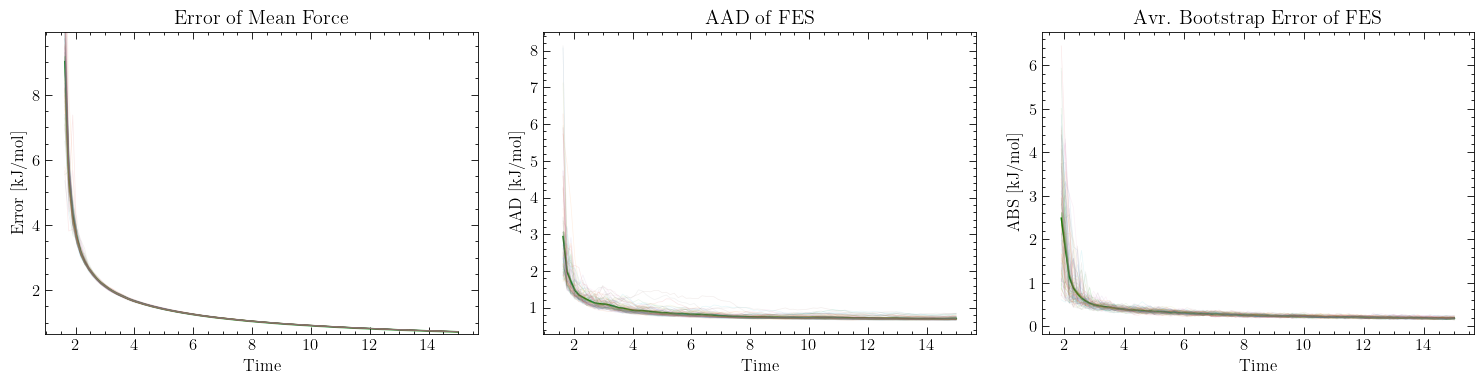

In [19]:
# Statistical Analysis of 100 MetaD ALTERNATIVE simulations
t_collection, aofe_collection, aad_collection, abs_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection), np.array(abs_collection)
t = t_collection[0]

avr_results = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection,
                                                return_results=True, plot=False, plot_log=False)
time_metadALT, mean_ofe_metadALT, ste_ofe_metadALT, mean_aad_metadALT, ste_aad_metadALT, mean_abs_metadALT, ste_abs_metadALT = avr_results
plt.subplot(1,3,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,3,3)
for i in range(len(abs_collection)): plt.plot(t, abs_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadALT[-1]:.4f} +- {ste_aad_metadALT[-1]:.4f}  || Mean Final ABS: {mean_abs_metadALT[-1]:.4f} +- {ste_abs_metadALT[-1]:.4f}")
plt.show()

### 2nd Stage - 2x MetaD simulations

In [10]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"len_error_list":100})
metadx2_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl, "base_forces_e_list":forces_e_list_expl})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if 1==2 and os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")

Analysis 1 | Final Error: Aofe = 0.7127, AAD = 0.6643, ABS = 0.3217
Analysis 2 | Final Error: Aofe = 0.7123, AAD = 0.6525, ABS = 0.2819
Analysis 3 | Final Error: Aofe = 0.7122, AAD = 0.6522, ABS = 0.3162
Analysis 4 | Final Error: Aofe = 0.7135, AAD = 0.6678, ABS = 0.2616
Analysis 5 | Final Error: Aofe = 0.7110, AAD = 0.6772, ABS = 0.2572
Analysis 6 | Final Error: Aofe = 0.7130, AAD = 0.6390, ABS = 0.2754
Analysis 7 | Final Error: Aofe = 0.7152, AAD = 0.6781, ABS = 0.2499
Analysis 8 | Final Error: Aofe = 0.7074, AAD = 0.6525, ABS = 0.2233
Analysis 9 | Final Error: Aofe = 0.7131, AAD = 0.6660, ABS = 0.4020
Analysis 10 | Final Error: Aofe = 0.7135, AAD = 0.6523, ABS = 0.2546
Analysis 11 | Final Error: Aofe = 0.7084, AAD = 0.6594, ABS = 0.2757
Analysis 12 | Final Error: Aofe = 0.7060, AAD = 0.6768, ABS = 0.2739
Analysis 13 | Final Error: Aofe = 0.7103, AAD = 0.6606, ABS = 0.2566
Analysis 14 | Final Error: Aofe = 0.7188, AAD = 0.6586, ABS = 0.2421
Analysis 15 | Final Error: Aofe = 0.7112, A

Mean Final AAD: 0.4171 +- 0.0062


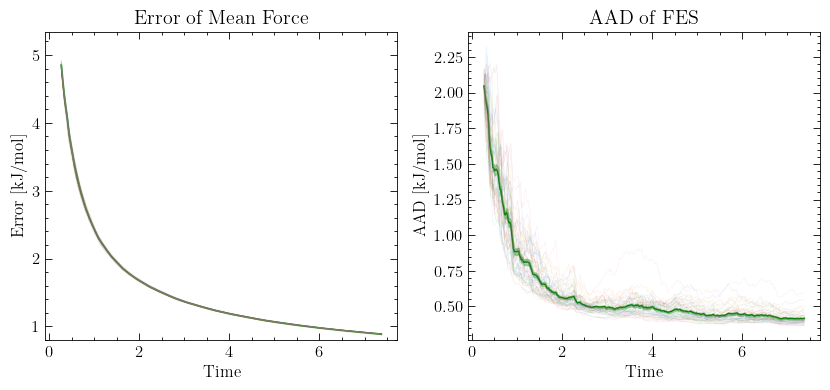

In [12]:
# Statistical Analysis of 50x2 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx2[-1]:.4f} +- {ste_aad_metadx2[-1]:.4f}")
plt.show()

In [11]:
# Patching of 50x2 MetaD simulations
metadx2_sim_params = {**default_params}
metadx2_sim_params.update({"len_error_list":100})
metadx2_sim_params.update({"base_forces":None, "base_time":sim_time_expl, "base_forces_e_list":None})

t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []

n_parallel = 2
parallel_efficiency = 0.75

for n_camp in range(1, 51):
    
    camp_ID = f"_metadx2ALT_{n_camp}"
    metadx2_sim_params.update({"ID":camp_ID})
    
    if 1==2 and os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx2 = MFI_class2D.MFI2D(**metadx2_sim_params)
        MFI_metadx2.make_external_bias(FES=fes_expl)
        mfi_parallel_x2 = MFI_metadx2.MFI_parallel(parent=MFI_metadx2, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x2.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x2.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x2.patch_simulations()
        t, v, aofe, aad, aBS = MFI_metadx2.Avr_Error_list[:,0], MFI_metadx2.Avr_Error_list[:,1], MFI_metadx2.Avr_Error_list[:,2], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.aad_index], MFI_metadx2.Avr_Error_list[:, MFI_metadx2.abs_error_index]
        lib2.save_pkl(np.array([t, v, aofe, aad, aBS]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}, ABS = {aBS[-1]:.4f}")

Analysis 1 | Final Error: Aofe = 0.6173, AAD = 0.6599, ABS = 0.1612
Analysis 2 | Final Error: Aofe = 0.6172, AAD = 0.7293, ABS = 0.1704
Analysis 3 | Final Error: Aofe = 0.6164, AAD = 0.6841, ABS = 0.1842
Analysis 4 | Final Error: Aofe = 0.6174, AAD = 0.6923, ABS = 0.1812
Analysis 5 | Final Error: Aofe = 0.6157, AAD = 0.6820, ABS = 0.1746
Analysis 6 | Final Error: Aofe = 0.6182, AAD = 0.6793, ABS = 0.1783
Analysis 7 | Final Error: Aofe = 0.6192, AAD = 0.6892, ABS = 0.1837
Analysis 8 | Final Error: Aofe = 0.6139, AAD = 0.6637, ABS = 0.1813
Analysis 9 | Final Error: Aofe = 0.6180, AAD = 0.6808, ABS = 0.1796
Analysis 10 | Final Error: Aofe = 0.6175, AAD = 0.6717, ABS = 0.1490
Analysis 11 | Final Error: Aofe = 0.6145, AAD = 0.6735, ABS = 0.1570
Analysis 12 | Final Error: Aofe = 0.6124, AAD = 0.7472, ABS = 0.1590
Analysis 13 | Final Error: Aofe = 0.6143, AAD = 0.6867, ABS = 0.1584
Analysis 14 | Final Error: Aofe = 0.6243, AAD = 0.6630, ABS = 0.1660
Analysis 15 | Final Error: Aofe = 0.6169, A

### 2nd Stage - 3x MetaD simulations

In [13]:
# Patching of 33x3 MetaD simulations
metadx3_sim_params = {**default_params}
metadx3_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx3_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 3
parallel_efficiency = 0.667

for n_camp in range(1, 34):
    
    camp_ID = f"_metadx3_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx3 = MFI_class2D.MFI2D(**metadx3_sim_params)
        MFI_metadx3.make_external_bias(FES=fes_expl)
        mfi_parallel_x3 = MFI_metadx3.MFI_parallel(parent=MFI_metadx3, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x3.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x3.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x3.patch_simulations()
        t, aofe, aad = MFI_metadx3.Avr_Error_list[:,0], MFI_metadx3.Avr_Error_list[:,2], MFI_metadx3.Avr_Error_list[:, MFI_metadx3.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.7649, AAD = 0.3898
Analysis 2 (exists) | Final Error: Aofe = 0.7678, AAD = 0.4800
Analysis 3 (exists) | Final Error: Aofe = 0.7644, AAD = 0.4179
Analysis 4 (exists) | Final Error: Aofe = 0.7673, AAD = 0.3839
Analysis 5 (exists) | Final Error: Aofe = 0.7636, AAD = 0.3980
Analysis 6 (exists) | Final Error: Aofe = 0.7652, AAD = 0.4419
Analysis 7 (exists) | Final Error: Aofe = 0.7678, AAD = 0.3718
Analysis 8 (exists) | Final Error: Aofe = 0.7680, AAD = 0.4297
Analysis 9 (exists) | Final Error: Aofe = 0.7684, AAD = 0.4068
Analysis 10 (exists) | Final Error: Aofe = 0.7669, AAD = 0.4369
Analysis 11 (exists) | Final Error: Aofe = 0.7675, AAD = 0.4047
Analysis 12 (exists) | Final Error: Aofe = 0.7688, AAD = 0.5875
Analysis 13 (exists) | Final Error: Aofe = 0.7686, AAD = 0.3938
Analysis 14 (exists) | Final Error: Aofe = 0.7679, AAD = 0.4078
Analysis 15 (exists) | Final Error: Aofe = 0.7666, AAD = 0.4092
Analysis 16 (exists) | Final Error: Aofe = 0.7656

Mean Final AAD: 0.4193 +- 0.0073


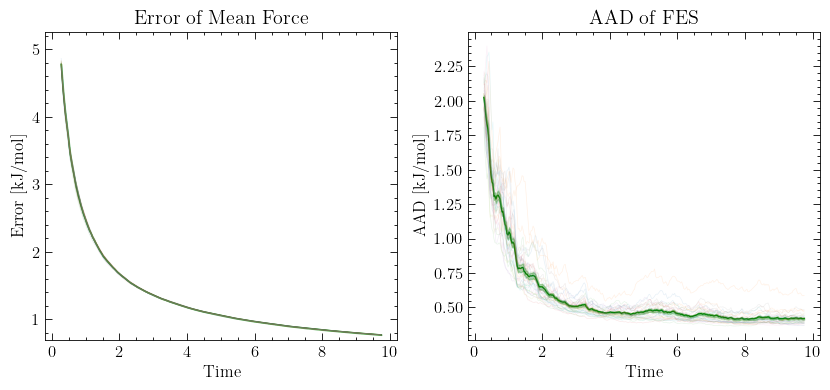

In [14]:
# Statistical Analysis of 33x3 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx3, mean_ofe_metadx3, ste_ofe_metadx3, mean_aad_metadx3, ste_aad_metadx3 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx3[-1]:.4f} +- {ste_aad_metadx3[-1]:.4f}")
plt.show()

### 2nd Stage - 4x MetaD simulations

In [15]:
# Patching of 25x4 MetaD simulations
metadx4_sim_params = {**default_params}
# metadx4_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx4_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 4
parallel_efficiency = 0.5

for n_camp in range(1, 26):
    
    camp_ID = f"_metadx4_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx4 = MFI_class2D.MFI2D(**metadx4_sim_params)
        MFI_metadx4.make_external_bias(FES=fes_expl)
        mfi_parallel_x4 = MFI_metadx4.MFI_parallel(parent=MFI_metadx4, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x4.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x4.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x4.patch_simulations()
        t, aofe, aad = MFI_metadx4.Avr_Error_list[:,0], MFI_metadx4.Avr_Error_list[:,2], MFI_metadx4.Avr_Error_list[:, MFI_metadx4.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")



Analysis 1 (exists) | Final Error: Aofe = 0.7578, AAD = 0.4426
Analysis 2 (exists) | Final Error: Aofe = 0.7598, AAD = 0.4279
Analysis 3 (exists) | Final Error: Aofe = 0.7595, AAD = 0.3953
Analysis 4 (exists) | Final Error: Aofe = 0.7548, AAD = 0.4275
Analysis 5 (exists) | Final Error: Aofe = 0.7582, AAD = 0.4129
Analysis 6 (exists) | Final Error: Aofe = 0.7624, AAD = 0.3865
Analysis 7 (exists) | Final Error: Aofe = 0.7571, AAD = 0.3914
Analysis 8 (exists) | Final Error: Aofe = 0.7584, AAD = 0.4030
Analysis 9 (exists) | Final Error: Aofe = 0.7598, AAD = 0.5444
Analysis 10 (exists) | Final Error: Aofe = 0.7583, AAD = 0.4012
Analysis 11 (exists) | Final Error: Aofe = 0.7617, AAD = 0.4234
Analysis 12 (exists) | Final Error: Aofe = 0.7580, AAD = 0.4215
Analysis 13 (exists) | Final Error: Aofe = 0.7568, AAD = 0.3936
Analysis 14 (exists) | Final Error: Aofe = 0.7612, AAD = 0.4003
Analysis 15 (exists) | Final Error: Aofe = 0.7571, AAD = 0.4410
Analysis 16 (exists) | Final Error: Aofe = 0.7547

Mean Final AAD: 0.4115 +- 0.0069


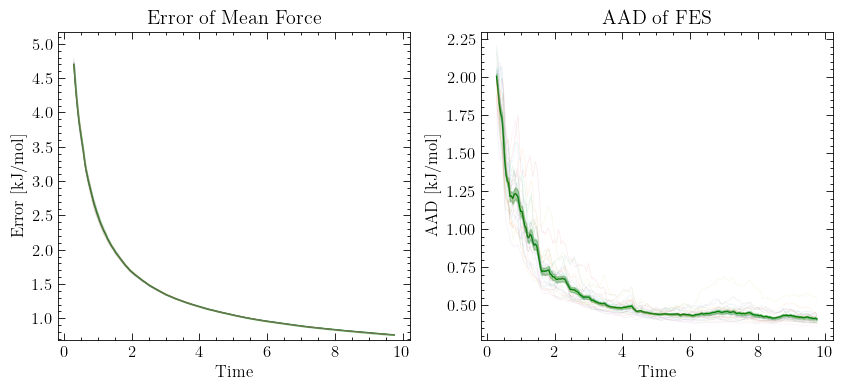

In [16]:
# Statistical Analysis of 25x4 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx4, mean_ofe_metadx4, ste_ofe_metadx4, mean_aad_metadx4, ste_aad_metadx4 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx4[-1]:.4f} +- {ste_aad_metadx4[-1]:.4f}")
plt.show()

### 2nd Stage 6x MetaD simulation

In [17]:
# Patching of 16x6 MetaD simulations
metadx6_sim_params = {**default_params}
# metadx6_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx6_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 6
parallel_efficiency = 0.4

for n_camp in range(1, 17):
    
    camp_ID = f"_metadx6_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx6 = MFI_class2D.MFI2D(**metadx6_sim_params)
        MFI_metadx6.make_external_bias(FES=fes_expl)
        mfi_parallel_x6 = MFI_metadx6.MFI_parallel(parent=MFI_metadx6, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x6.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x6.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x6.patch_simulations()
        t, aofe, aad = MFI_metadx6.Avr_Error_list[:,0], MFI_metadx6.Avr_Error_list[:,2], MFI_metadx6.Avr_Error_list[:, MFI_metadx6.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.6889, AAD = 0.4595
Analysis 2 (exists) | Final Error: Aofe = 0.6884, AAD = 0.4704
Analysis 3 (exists) | Final Error: Aofe = 0.6851, AAD = 0.3912
Analysis 4 (exists) | Final Error: Aofe = 0.6923, AAD = 0.4045
Analysis 5 (exists) | Final Error: Aofe = 0.6876, AAD = 0.4200
Analysis 6 (exists) | Final Error: Aofe = 0.6892, AAD = 0.5372
Analysis 7 (exists) | Final Error: Aofe = 0.6896, AAD = 0.4487
Analysis 8 (exists) | Final Error: Aofe = 0.6875, AAD = 0.4302
Analysis 9 (exists) | Final Error: Aofe = 0.6904, AAD = 0.4136
Analysis 10 (exists) | Final Error: Aofe = 0.6872, AAD = 0.4088
Analysis 11 (exists) | Final Error: Aofe = 0.6864, AAD = 0.4455
Analysis 12 (exists) | Final Error: Aofe = 0.6910, AAD = 0.3746
Analysis 13 (exists) | Final Error: Aofe = 0.6894, AAD = 0.3840
Analysis 14 (exists) | Final Error: Aofe = 0.6885, AAD = 0.4054
Analysis 15 (exists) | Final Error: Aofe = 0.6884, AAD = 0.3925
Analysis 16 (exists) | Final Error: Aofe = 0.6854

Mean Final AAD: 0.4266 +- 0.0098


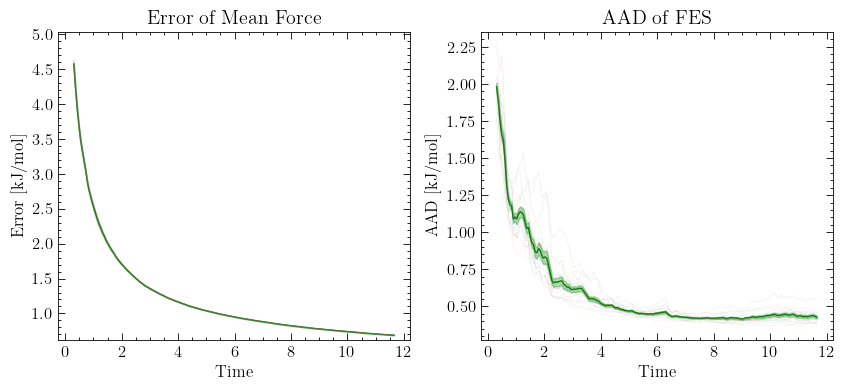

In [18]:
# Statistical Analysis of 16x6 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx6, mean_ofe_metadx6, ste_ofe_metadx6, mean_aad_metadx6, ste_aad_metadx6 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx6[-1]:.4f} +- {ste_aad_metadx6[-1]:.4f}")
plt.show()

### 2nd Stage 10x MetaD simulation

In [19]:
# Patching of 10x10 MetaD simulations
metadx10_sim_params = {**default_params}
# metadx10_sim_params.update({"simulation_steps":633_333, "len_error_list":320})#, "n_pos":31_667}) # 
metadx10_sim_params.update({"base_forces":force_terms_expl, "base_time":sim_time_expl})#, "base_forces_e_list":base_forces_e_list})

t_collection, aofe_collection, aad_collection = [], [], []

n_parallel = 10
parallel_efficiency = 0.3

for n_camp in range(1, 11):
    
    camp_ID = f"_metadx10_{n_camp}"
    new_params.update({"ID":camp_ID})
    
    if os.path.isfile(path_data + f"error_progression{camp_ID}.pkl"):
        print(f"Analysis {n_camp} (exists)", end=" | ")
        t, aofe, aad = lib2.load_pkl(path_data + f"error_progression{camp_ID}.pkl")
        
    else:   
        print(f"Analysis {n_camp}", end=" | ")

        MFI_metadx10 = MFI_class2D.MFI2D(**metadx10_sim_params)
        MFI_metadx10.make_external_bias(FES=fes_expl)
        mfi_parallel_x10 = MFI_metadx10.MFI_parallel(parent=MFI_metadx10, workers=n_parallel)

        camp_sim = 0
        for i_sim in range((n_camp-1)*n_parallel+1, (n_camp)*n_parallel+1):
            res = lib2.load_pkl(path_data + f"MFI_results_metad_{i_sim}.pkl")
            mfi_parallel_x10.sim[camp_sim].Avr_Error_list = res[1][1][:int(len(res[1][1])*parallel_efficiency)]
            mfi_parallel_x10.sim[camp_sim].forces_e_list = res[1][2][:int(len(res[1][2])*parallel_efficiency)]
            camp_sim += 1 

        mfi_parallel_x10.patch_simulations()
        t, aofe, aad = MFI_metadx10.Avr_Error_list[:,0], MFI_metadx10.Avr_Error_list[:,2], MFI_metadx10.Avr_Error_list[:, MFI_metadx10.aad_index]
        lib2.save_pkl(np.array([t, aofe, aad]), path_data + f"error_progression{camp_ID}.pkl")

    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad)        
    print(f"Final Error: Aofe = {aofe[-1]:.4f}, AAD = {aad[-1]:.4f}")


Analysis 1 (exists) | Final Error: Aofe = 0.6115, AAD = 0.4377
Analysis 2 (exists) | Final Error: Aofe = 0.6096, AAD = 0.3990
Analysis 3 (exists) | Final Error: Aofe = 0.6105, AAD = 0.3979
Analysis 4 (exists) | Final Error: Aofe = 0.6114, AAD = 0.4074
Analysis 5 (exists) | Final Error: Aofe = 0.6133, AAD = 0.4414
Analysis 6 (exists) | Final Error: Aofe = 0.6107, AAD = 0.3878
Analysis 7 (exists) | Final Error: Aofe = 0.6110, AAD = 0.3828
Analysis 8 (exists) | Final Error: Aofe = 0.6139, AAD = 0.3802
Analysis 9 (exists) | Final Error: Aofe = 0.6112, AAD = 0.3913
Analysis 10 (exists) | Final Error: Aofe = 0.6113, AAD = 0.3948


Mean Final AAD: 0.4020 +- 0.0064


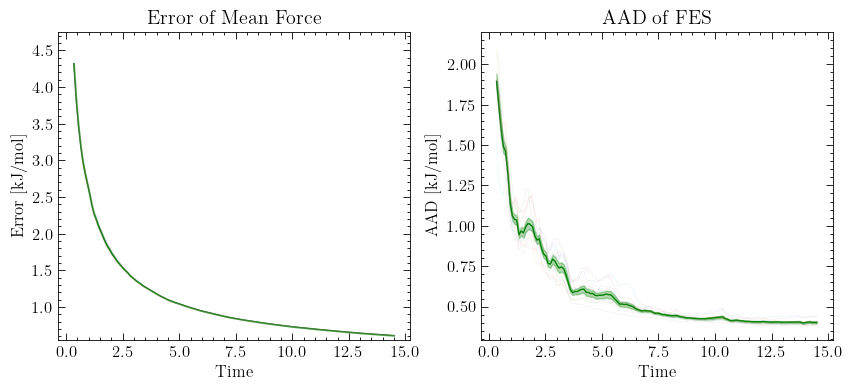

In [20]:
# Statistical Analysis of 10x10 MetaD simulations
t_collection, aofe_collection, aad_collection = np.array(t_collection), np.array(aofe_collection), np.array(aad_collection)
t = t_collection[0]

time_metadx10, mean_ofe_metadx10, ste_ofe_metadx10, mean_aad_metadx10, ste_aad_metadx10 = lib2.get_mean_ste_of_n_error_prog(time=t, error_collection=aofe_collection, error_collection_2=aad_collection, 
                                                                                                        return_results=True, plot=False, plot_log=False)
plt.subplot(1,2,1) 
for i in range(len(aofe_collection)): plt.plot(t, aofe_collection[i], linewidth=0.5, alpha=0.1)
plt.subplot(1,2,2)
for i in range(len(aad_collection)): plt.plot(t, aad_collection[i], linewidth=0.5, alpha=0.1)
print(f"Mean Final AAD: {mean_aad_metadx10[-1]:.4f} +- {ste_aad_metadx10[-1]:.4f}")
plt.show()

### Compare Convergence of Simulations

In [21]:
# import gaussian_filter
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data


In [6]:
### laod results

# long simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,21):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_long_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_long, mean_ofe_long, ste_ofe_long, mean_aad_long, ste_aad_long, mean_abs_long, ste_abs_long = avr_results
plt.close()

# exploration simulation
t_expl, _, aofe_expl, aad_expl, abs_expl = lib2.load_pkl(path_data + f"MFI_results_expl_1.pkl")[1][1].T

# metad simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,101):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metad_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad, mean_abs_metad, ste_abs_metad = avr_results
plt.close()

# metad ALTERNATIVE simulation
t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
for i_sim in range(1,101):
    t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadALT_{i_sim}.pkl")
    t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
time_metadALT, mean_ofe_metadALT, ste_ofe_metadALT, mean_aad_metadALT, ste_aad_metadALT, mean_abs_metadALT, ste_abs_metadALT = avr_results
plt.close()

# # metadx2 ALTERNATIVE simulation
# t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
# for i_sim in range(1,51):
#     t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadx2_{i_sim}.pkl")
#     t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
# avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
# time_metadx2, mean_ofe_metadx2, ste_ofe_metadx2, mean_aad_metadx2, ste_aad_metadx2, mean_abs_metadx2, ste_abs_metadx2 = avr_results
# plt.close()

# # metadx2 ALTERNATIVE simulation
# t_collection, aofe_collection, aad_collection, abs_collection = [], [], [], []
# for i_sim in range(1,51):
#     t, _, aofe, aad, aBS = lib2.load_pkl(path_data + f"error_progression_metadx2ALT_{i_sim}.pkl")
#     t_collection.append(t); aofe_collection.append(aofe); aad_collection.append(aad); abs_collection.append(aBS)
# avr_results = lib2.get_mean_ste_of_n_error_prog(time=t_collection[0], error_collection=aofe_collection, error_collection_2=aad_collection, error_collection_3=abs_collection, return_results=True, plot=False, plot_log=False)
# time_metadx2ALT, mean_ofe_metadx2ALT, ste_ofe_metadx2ALT, mean_aad_metadx2ALT, ste_aad_metadx2ALT, mean_abs_metadx2ALT, ste_abs_metadx2ALT = avr_results
# plt.close()

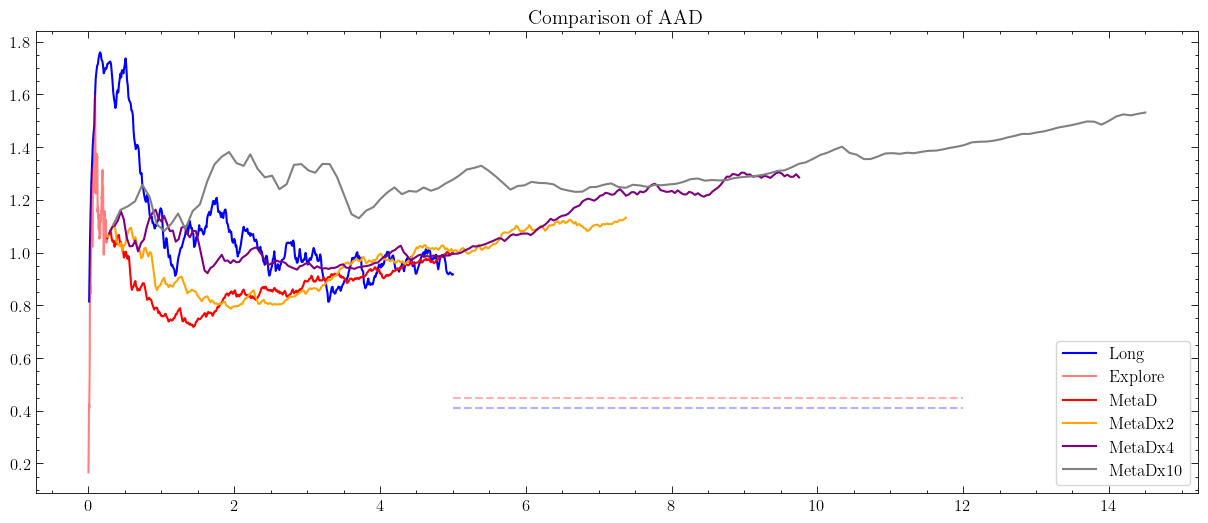

In [22]:
plt.figure(figsize=(15,6))
# plt.figure(figsize=(20,4))
# # time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

# plt.subplot(1,2,1)
# plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
# # plt.plot(time_expl, mean_ofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
# plt.plot(time_metad, mean_ofe_metad, label="MetaD", color="red")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# # plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# # plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
# plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

# plt.subplot(1,2,2)
plt.plot(time_long, np.sqrt(time_long)*sf(mean_aad_long), label="Long", color="blue"); plt.plot([time_long[-1], 12], [mean_aad_long[-1],mean_aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
# plt.plot(time_expl, mean_aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(t_expl, np.sqrt(t_expl)*sf(aad_expl), label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, np.sqrt(time_metad)*sf(mean_aad_metad), label="MetaD", color="red"); plt.plot([time_metad[-1], 12], [mean_aad_metad[-1],mean_aad_metad[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadx2, np.sqrt(time_metadx2)*sf(mean_aad_metadx2), label="MetaDx2", color="orange")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
plt.plot(time_metadx4, np.sqrt(time_metadx4)*sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
plt.plot(time_metadx10, np.sqrt(time_metadx10)*mean_aad_metadx10, label="MetaDx10", color="grey")

# plt.ylim(0.38, 3)
# plt.xlim(0, 5)
# plt.yscale("log"); 
plt.legend(); plt.title("Comparison of AAD"); plt.show()

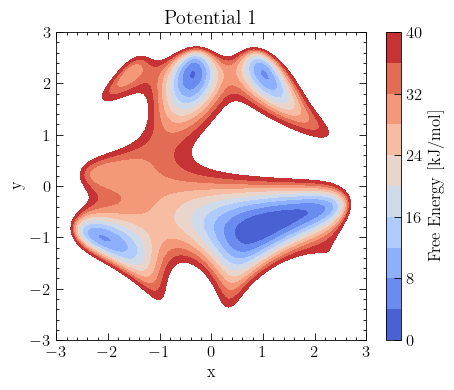

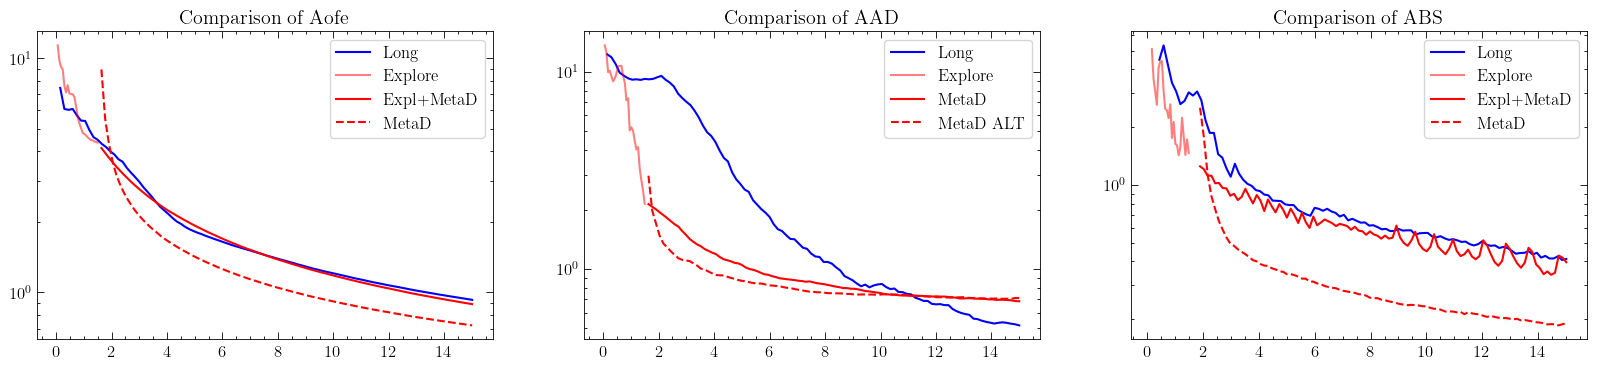

In [7]:
from scipy.signal import savgol_filter

def sf(data, window_length=None, polyorder=None):
    # if window_length is None: window_length = int(len(data)/10)
    # if polyorder is None: polyorder = 2
    # return savgol_filter(data, window_length, polyorder)
    return data

plt.figure(figsize=(5,4))
# plot pit1
plt.contourf(X, Y, pot3, levels=np.linspace(0, 40, 11), cmap='coolwarm'); plt.colorbar(label="Free Energy [kJ/mol]"); plt.xlabel("x"); plt.ylabel("y"); plt.title("Potential 1"); plt.show()

plt.figure(figsize=(20,4))
# time_metad, mean_ofe_metad, ste_ofe_metad, mean_aad_metad, ste_aad_metad

plt.subplot(1,3,1)
plt.plot(time_long, mean_ofe_long, label="Long", color="blue")
plt.plot(t_expl, aofe_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, mean_ofe_metad, label="Expl+MetaD", color="red")
plt.plot(time_metadALT, mean_ofe_metadALT, label="MetaD", color="red", linestyle="--")
# plt.plot(time_metadx2, mean_ofe_metadx2, label="MetaDx2", color="orange")
# plt.plot(time_metadx2ALT, mean_ofe_metadx2ALT, label="Expl+MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, mean_ofe_metadx3, label="MetaDx3", color="green")
# plt.plot(time_metadx4, mean_ofe_metadx4, label="MetaDx4", color="purple")
# plt.plot(time_metadx6, mean_ofe_metadx6, label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, mean_ofe_metadx10, label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of Aofe")

plt.subplot(1,3,2)
plt.plot(time_long, sf(mean_aad_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t_expl, aad_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_aad_metad), label="MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_aad_metadALT), label="MetaD ALT", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, sf(mean_aad_metadx2), label="MetaDx2", color="orange")
# plt.plot(time_metadx2, sf(mean_aad_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_aad_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of AAD"); 
# plt.xlim(0,10)

plt.subplot(1,3,3)
plt.plot(time_long, sf(mean_abs_long), label="Long", color="blue"); #plt.plot([t_long[-1],t1x4[-1]], [aad_long[-1],aad_long[-1]], color="blue", linestyle="--", alpha=0.3)
plt.plot(t_expl, abs_expl, label="Explore", color="red", alpha=0.5)
plt.plot(time_metad, sf(mean_abs_metad), label="Expl+MetaD", color="red");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
plt.plot(time_metadALT, sf(mean_abs_metadALT), label="MetaD", color="red", linestyle="--");#plt.plot([t1x1[-1],t1x4[-1]], [aad1x1[-1],aad1x1[-1]], color="red", linestyle="--", alpha=0.3)
# plt.plot(time_metadx2, sf(mean_abs_metadx2), label="Expl+MetaDx2", color="orange")
# plt.plot(time_metadx2ALT, sf(mean_abs_metadx2ALT), label="MetaDx2", color="orange", linestyle="--")
# plt.plot(time_metadx3, sf(mean_aad_metadx3), label="MetaDx3", color="green")
# plt.plot(time_metadx4, sf(mean_aad_metadx4), label="MetaDx4", color="purple")
# plt.plot(time_metadx6, sf(mean_aad_metadx6), label="MetaDx6", color="aquamarine")
# plt.plot(time_metadx10, sf(mean_aad_metadx10), label="MetaDx6", color="grey")
plt.legend(); plt.yscale("log"); plt.title("Comparison of ABS"); 
# plt.ylim(0.38, 0.6)

plt.show()

